In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cython
from mc_lib.lattices import tabulate_neighbors

%matplotlib inline

In [2]:
eps = 0.01
pc_ini = .5
eps = 0.01
pc_ini = .5
bs_ini = np.linspace(9/8, 3/2, num=30) + eps

interval0 = np.linspace(bs_ini[0], bs_ini[1], num=10)
interval1 = np.linspace(bs_ini[2], bs_ini[3], num=10)
temp0 = np.hstack((interval0, interval1))

interval2 = np.linspace(bs_ini[5], bs_ini[6], num=10)
temp1 = np.hstack((temp0, interval2))

interval3 = np.linspace(bs_ini[8], bs_ini[9], num=10)
temp2 = np.hstack((temp1, interval3))

interval4 = np.linspace(bs_ini[15], bs_ini[16], num=10)
bs_temp = np.hstack((temp2, interval4))

bs = np.array([bs_temp[0], bs_temp[6], bs_temp[15], bs_temp[21], bs_temp[39], bs_temp[44]])

seeds = np.array([i for i in range(1, 51)])
n = len(seeds)
m = len(bs)
L = 60
burn = 2 * 10**4
evol = 50
seeds = np.array([i for i in range(1, 16)])
n = len(seeds)
m = len(bs)
L = 60
evol = L**2 * 10**2

In [3]:
%load_ext cython

In [4]:
%%cython --cplus
import cython
import numpy as np
from mc_lib.rndm cimport RndmWrapper
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)

def get_rw(seed):
    cdef RndmWrapper rndm = RndmWrapper(seed=(seed, 0))
    return rndm

def evolve_C_2(field_orig, RndmWrapper rndm, int[:, :] neighbors, double b, int steps, int seed):
    '''
    ---Эволюция поля на Cython с RndmWrapper---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша
    - steps - количество шагов эволюции. За один шаг происходит эволюция одного случайного агента
    
    -------------------
    '''
    
    # обьявление переменных
    
    cdef int [:] field = field_orig.flatten() # переводим двумерный массив в одномерный
    
    cdef int N_NEIGHBR = neighbors.shape[1]
    
    cdef int step, x, n_id, j, y
    
    cdef int L = field.shape[0]
    
    cdef double scorex, scorey
    
    for step in range(steps):
        scorex = 0
        x = int(rndm.uniform() * L)
        for n_id in range(N_NEIGHBR):
            if field[neighbors[x, n_id]] == 0:
                scorex += 1
        if field[x] == 1:
            scorex *= b
        
        scorey = 0
        y = int(rndm.uniform() * N_NEIGHBR)
        y = neighbors[x, y]
        for n_id in range(N_NEIGHBR):
                if field[neighbors[y, n_id]] == 0:
                    scorey += 1
        if field[y] == 1:
            scorey *= b
        if scorey > scorex:
            field[x] = field[y]
    SHAPE = field_orig.shape
    field_orig = np.array(field)
    return np.reshape(field_orig, SHAPE)

In [5]:
def make_field(size, pc_initial):
    '''
    ---Формирование поля для одного seed---
    
    принимает на вход
    - size - размер поля
    - pc_initial - начальная плотность кооператоров
    
    возвращает
    - field - поле по заданным начальным условиям, где 1 - дефектор, 0 - кооператор
    
    ---------------------------------------
    '''
    field = np.array(np.random.rand(size, size) > pc_initial, dtype=int)
    return field
            
def calculate_pc(size, pc_initial, b, evol_steps, seed):
    '''
    ---Вычисление плотности кооператоров---
    
    принимает на вход
    - size
    - pc_initial
    - b
    - evol_steps - шаги эволюции
    - seed - начальное условие генератора для повторяемости результата
    
    возвращает
    - pc - плотность кооператоров на протяжении evol_steps шагов
    
    ---------------------------------------
    '''
    np.random.seed(seed)
    pc = np.zeros(evol_steps + 1)
    field = make_field(size, pc_initial)
    pc[0] = np.count_nonzero(field - 1) / (size * size)
    rndm = get_rw(seed)
    neighbors = tabulate_neighbors((size, size, 1), 'root-two')
    for step in range(evol_steps):
        field = evolve_C_2(field, rndm, neighbors, b, size * size, seed)
        pc[step + 1] = np.count_nonzero(field - 1) / (size * size)
    
    return pc

In [6]:
pc = np.zeros((n, m, evol + 1))

In [7]:
for i in range(n):
    for j in range(m):
        pc[i, j] = calculate_pc(L, pc_ini, bs[j], evol, seeds[i])

In [10]:
average_over_replicas = np.mean(pc, axis=0)

C:\Users\79155\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


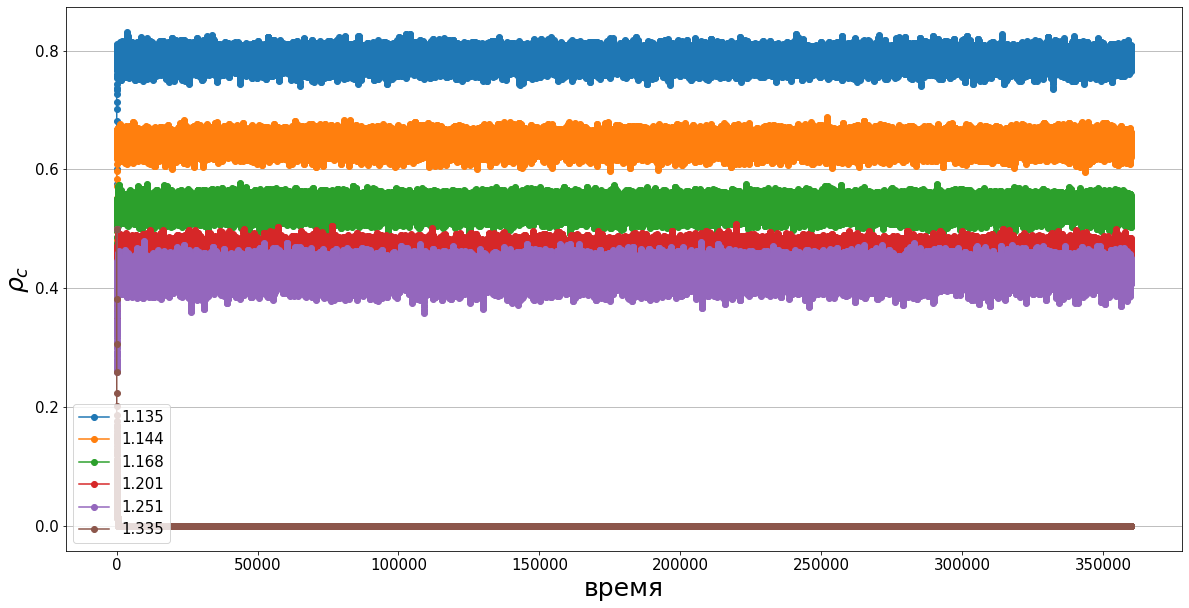

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for i in range(m):
    ax.plot(average_over_replicas[i], 'o-', label=np.round(bs[i], decimals=3))
    
ax.set_xlabel('время',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

### Стандартная ошибка среднего (по реализациям)

Вычисляется как $\frac{\sqrt{\frac{1}{n}\sum\limits_{j=1}^n{(\rho_j - \overline{\rho})}^2}}{\sqrt{n}}$, где

$\rho_j$ - значение плотности для одной реализации

$\overline{\rho}$ - среднее значение плотности по реализациям

$n$ - количество реализаций

In [31]:
err = np.zeros((m, evol + 1))
for j in range(m):
    for step in range(evol + 1):
        err[j, step] = np.sqrt(sum((pc[:, j, step] - average_over_replicas[j, step]) ** 2) / n) / np.sqrt(n)

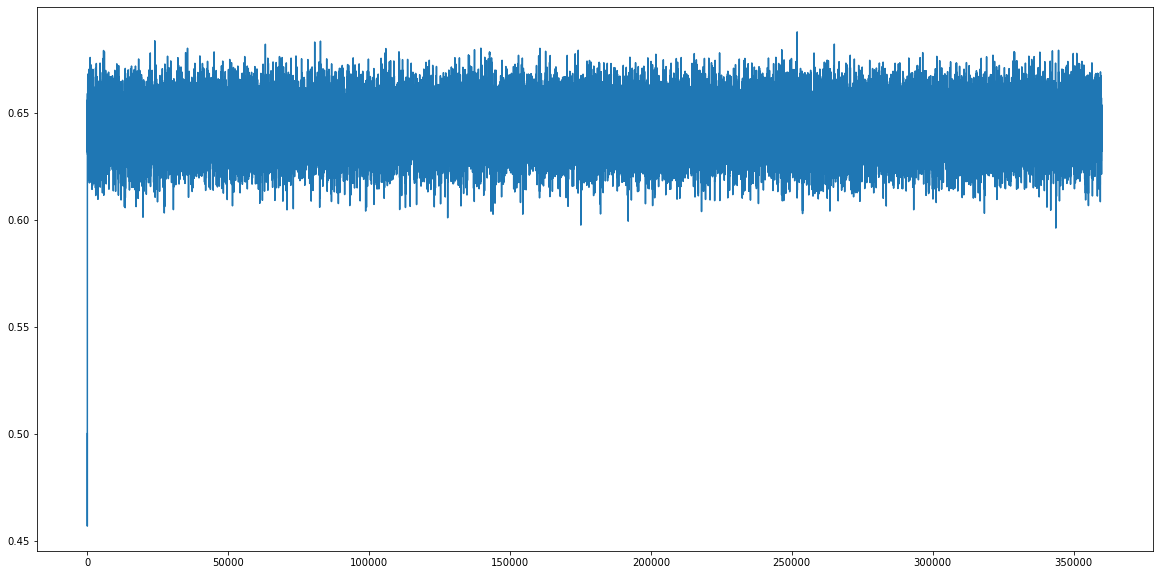

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(average_over_replicas[1])
    